In [38]:
import os

# Biopython
import Bio
from Bio import SeqIO

import subprocess

# some Python standard lib
import gzip
import random
import glob

# python modules for data analysis
import numpy as np
import scipy
import pandas as pd

# plotting of data
import matplotlib.pyplot as plt
import seaborn as sns

from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIWWW, NCBIXML

In [8]:
input = "barcodes/barcode03"
unique_fastq = "merged_output.fastq"
fasta_input = "fastab03"

In [6]:
def calculate_gc_content(sequence):
    gc_count = sum(1 for base in sequence if base in "GC")
    return (gc_count / len(sequence)) * 100 if len(sequence) > 0 else 0
    
def fastq_to_fasta(input_fastq, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.basename(input_fastq)[:-9]   # Strip .fastq or .fastq.gz
    output_fasta = os.path.join(output_dir, base_name + ".fasta")
    with gzip.open(input_fastq, "rt") as fastq, open(output_fasta, "w") as fasta:
        SeqIO.convert(fastq, "fastq", fasta, "fasta")
    return output_fasta

In [12]:
all_reads_data = []
sequences = []
for filename in os.listdir(input):
    if filename.endswith(".fastq.gz"):
        file_path = os.path.join(input, filename)
        fastq_to_fasta(file_path, fasta_input)
        handle = gzip.open(file_path, "rt") 

        with handle:
            for record in SeqIO.parse(handle, "fastq"):
                read_id = record.id
                sequence = str(record.seq)
                sequences.append(sequence)
                quality_scores = record.letter_annotations["phred_quality"]

                read_length = len(sequence)
                average_quality = sum(quality_scores) / len(quality_scores) if quality_scores else 0
                gc_content = calculate_gc_content(sequence)

                all_reads_data.append({
                    "File": filename,
                    "Read ID": read_id,
                    "Length": read_length,
                    "Average Quality": average_quality,
                    "GC Content (%)": gc_content
                })


In [98]:
fasta_files = glob.glob("fastab01/*.fasta")  

output_file = "combined_sequences.fasta"

with open(output_file, "w") as outfile:
    for file in fasta_files:
        with open(file, "r") as infile:
            for record in SeqIO.parse(infile, "fasta"):
                SeqIO.write(record, outfile, "fasta")

print(f"✅ Combined {len(fasta_files)} FASTA files into {output_file}")


✅ Combined 430 FASTA files into combined_sequences.fasta


In [16]:
df = pd.DataFrame(all_reads_data)
df

File  \
0       FBA04822_pass_barcode01_a95aace0_baba7488_226....   
1       FBA04822_pass_barcode01_a95aace0_baba7488_226....   
2       FBA04822_pass_barcode01_a95aace0_baba7488_226....   
3       FBA04822_pass_barcode01_a95aace0_baba7488_226....   
4       FBA04822_pass_barcode01_a95aace0_baba7488_226....   
...                                                   ...   
156813  FBA04822_pass_barcode01_a95aace0_baba7488_164....   
156814  FBA04822_pass_barcode01_a95aace0_baba7488_164....   
156815  FBA04822_pass_barcode01_a95aace0_baba7488_164....   
156816  FBA04822_pass_barcode01_a95aace0_baba7488_164....   
156817  FBA04822_pass_barcode01_a95aace0_baba7488_164....   

                                     Read ID  Length  Average Quality  \
0       f56c7525-c13c-402c-a8e0-2a890a88e086    4326        15.148405   
1       3cc5ce41-eb4f-4cdd-86c8-a81458ebbfea     596        15.989933   
2       cec77d7a-0dd6-41e0-9b25-77ffad19c979     867        16.303345   
3       07f5ceee-c450-4108-89f4-97d967d3d44f    3878        13.923930   
4       b46cd5e7-1d35-4afd-b9e9-8d1416aa5beb     863        14.170336   
...                                      ...     ...              ...   
156813  7a759737-392e-4359-9834-d07ba084cdda     685        14.715328   
156814  59756458-77b0-4056-b104-d64d7aaaed78     708        14.014124   
156815  f5c69598-f4c0-4bc3-8427-52cc9e019b11    9712        14.045099   
156816  9cdc6457-dca7-49ac-a3d9-5d7851e7fffb     566        15.726148   
156817  4be84b2b-5b6b-4a7a-863a-8e4c53d9ba1b   47561        19.785391   

        GC Content (%)  
0            54.045307  
1            52.181208  
2            46.828143  
3            51.186178  
4            42.641947  
...                ...  
156813       53.576642  
156814       53.248588  
156815       42.051071  
156816       49.116608  
156817       38.083724  

[156818 rows x 5 columns]

In [22]:
os.system(f"NanoPlot --fastq {unique_fastq} -o {"NanoPlotRes"}")

Fatal: No reads found in input.


256

In [149]:
# sequences exists, retriving file names
names = df['Read ID']
print(names[0])

f56c7525-c13c-402c-a8e0-2a890a88e086


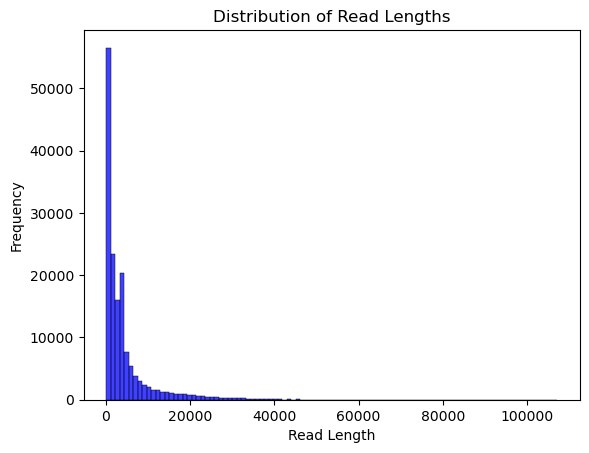

In [22]:
sns.histplot(df['Length'], kde=False, bins=100, color='blue')  
plt.title("Distribution of Read Lengths")
plt.xlabel("Read Length")
plt.ylabel("Frequency")
plt.show()

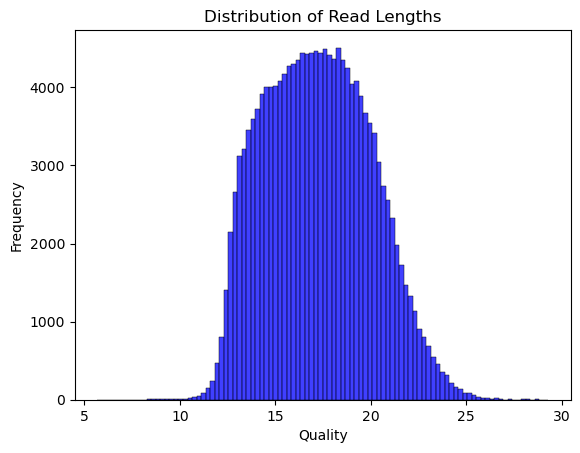

In [23]:
sns.histplot(df['Average Quality'], kde=False, bins=100, color='blue')  
plt.title("Distribution of Read Lengths")
plt.xlabel("Quality")
plt.ylabel("Frequency")
plt.show()

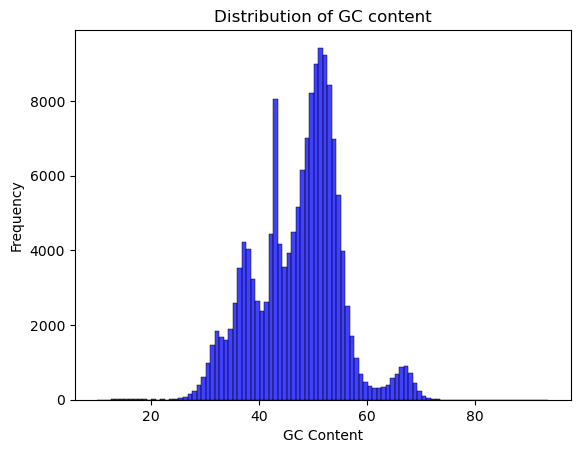

In [24]:
sns.histplot(df['GC Content (%)'], kde=False, bins=100, color='blue')  
plt.title("Distribution of GC content")
plt.xlabel("GC Content")
plt.ylabel("Frequency")
plt.show()

Mapping 

Running cmsearch

In [31]:
def run_cmsearch(fasta_dir, cm_model, output_dir, cpu = 8, threshold = 500):
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(fasta_dir):
        if filename.endswith(".fasta"):
            fasta_path = os.path.join(fasta_dir, filename)
            output_path = os.path.join(output_dir, f"hits_{filename}.csv")
            
            command = (
                f"cmsearch --cpu {cpu} --noali --notrunc -g -T {threshold} "
                f"--tblout {output_path} {cm_model} {fasta_path}"
            )
            print(f"Running cmsearch on {filename}...")
            os.system(command)

For bacteria:

In [36]:
fasta_dir = "fastab01"        
cm_model = "data/RF00177.cm"     
output_dir = "hits"               

# Run cmsearch on all .fasta files
run_cmsearch(fasta_dir, cm_model, output_dir)

Running cmsearch on FBA04822_pass_barcode01_a95aace0_baba7488_297.fasta...
# cmsearch :: search CM(s) against a sequence database
# INFERNAL 1.1.5 (Sep 2023)
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# query CM file:                         data/RF00177.cm
# target sequence database:              fastab01/FBA04822_pass_barcode01_a95aace0_baba7488_297.fasta
# CM configuration:                      glocal
# tabular output of hits:                hits/hits_FBA04822_pass_barcode01_a95aace0_baba7488_297.fasta.csv
# show alignments in output:             no
# sequence reporting threshold:          score >= 500
# truncated sequence detection:          off
# number of worker threads:              8 [--cpu]
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Query:       SSU_rRNA_bacteria  [CLEN=1533]
Accession:   RF00177
Descriptio

In [38]:
folder_path = "hits"
all_dataframes = []
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        
        try:
            df = pd.read_csv(file_path, sep="\s+", header=None, comment="#")
            
            if not df.empty and df.shape[1] > 0:
                all_dataframes.append(df)
            else:
                print(f"Skipping empty or malformed file: {file_name}")
        
        except pd.errors.EmptyDataError:
            # Handle empty CSV files
            print(f"Skipping empty file: {file_name}")
        
        except pd.errors.ParserError:
            # Handle parsing errors (e.g., if the file is not a valid CSV)
            print(f"Skipping malformed file: {file_name}")
        
        except Exception as e:
            # General exception handler for any other errors
            print(f"Error reading {file_name}: {e}")



<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/var/folders/jg/0ky1rst55w59tncf1d8dt3900000gn/T/ipykernel_33196/4135223257.py:9: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep="\s+", header=None, comment="#")


Skipping empty file: hits_FBA04822_pass_barcode01_a95aace0_baba7488_131.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode01_a95aace0_baba7488_307.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode01_a95aace0_baba7488_313.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode01_a95aace0_baba7488_369.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode01_a95aace0_baba7488_196.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode01_a95aace0_baba7488_332.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode01_a95aace0_baba7488_348.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode01_a95aace0_baba7488_395.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode01_a95aace0_baba7488_326.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode01_a95aace0_baba7488_236.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode01_a95aace0_baba7488_416.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode01_a95aace0_baba7488_285.fasta.csv
Skipping empty f

In [40]:
if all_dataframes:
    combined_df = pd.concat(all_dataframes)
combined_df
combined_df.to_csv("temp1.csv", index=False)

In [26]:
df = pd.read_csv("temp1.csv")
df = df.drop(columns=["1", "4", "5", "10", "11", "16", "17", "19", "20", "21", "22", "23", "24", "25", "26"]) 
df.columns = ["seq_id", "cm_type", "-", "+", "Seq from", "Seq to", "Strand", "GC", "Bias", "Score", "E-value", "Description of target"] 
df


seq_id            cm_type        -     +  \
0    a50104fc-fdb3-4b6d-9f1c-0c0e147cfca7  SSU_rRNA_bacteria  RF00177  1533   
1    f43b01e0-2415-4ade-9c39-f4f3910be01f  SSU_rRNA_bacteria  RF00177  1533   
2    022eb210-9850-4a7b-8f70-43515a63c71c  SSU_rRNA_bacteria  RF00177  1533   
3    3ed3cdb5-ccc2-4edb-bd31-df082ae788c7  SSU_rRNA_bacteria  RF00177  1533   
4    a637715a-0a8e-4294-8a9f-6afed130385f  SSU_rRNA_bacteria  RF00177  1533   
..                                    ...                ...      ...   ...   
774  8bb671d1-86c7-4ada-8c3f-c21d97816368  SSU_rRNA_bacteria  RF00177  1533   
775  d5b49941-3085-477b-9aab-77a98191e08f  SSU_rRNA_bacteria  RF00177  1533   
776  092707c8-ac5b-43a9-82e7-d3543a6c101a  SSU_rRNA_bacteria  RF00177  1533   
777  f5e43090-32f9-4637-b458-729e83aed9fb  SSU_rRNA_bacteria  RF00177  1533   
778  ff382f83-b9d5-449f-b221-749fd82d1a05  SSU_rRNA_bacteria  RF00177  1533   

     Seq from  Seq to Strand    GC  Bias   Score       E-value  \
0        4918    3388      -  0.50   0.0   899.7  1.800000e-29   
1        2493    4010      +  0.55  14.2  1112.7  7.500000e-35   
2        4990    6538      +  0.54   6.0  1270.0  3.200000e-39   
3        2141    3696      +  0.55   9.1  1236.4  2.900000e-38   
4        8657    7263      -  0.52   0.3   943.5  5.200000e-30   
..        ...     ...    ...   ...   ...     ...           ...   
774      1937     415      -  0.54   3.4  1089.3  6.800000e-34   
775      1123    2648      +  0.54  12.6  1072.0  2.100000e-33   
776      5835    4308      -  0.54   7.9  1071.0  2.300000e-33   
777      2981    1470      -  0.53   5.4  1062.9  3.800000e-33   
778      9177   10685      +  0.55  10.1   847.2  4.600000e-27   

    Description of target  
0                  ch=112  
1                  ch=188  
2                  ch=137  
3                   ch=28  
4                  ch=454  
..                    ...  
774                ch=263  
775                ch=362  
776                 ch=64  
777                ch=362  
778                ch=368  

[779 rows x 12 columns]

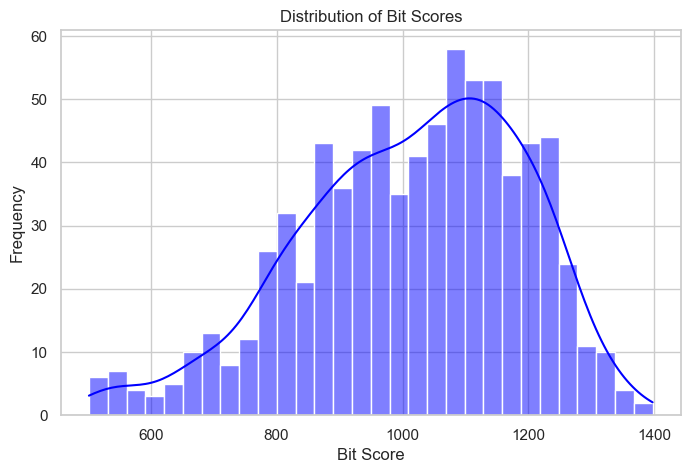

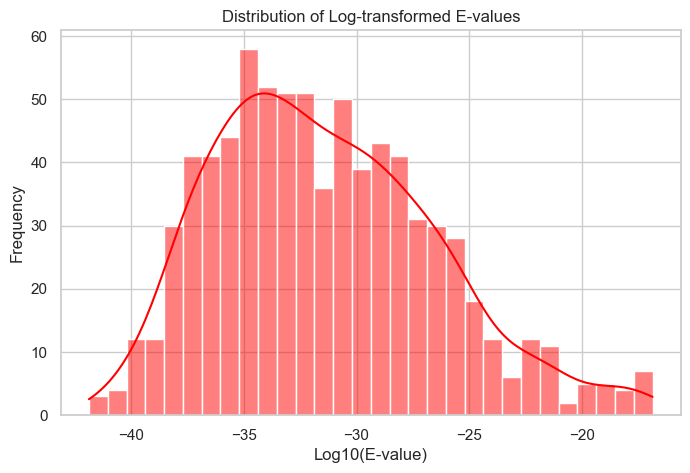

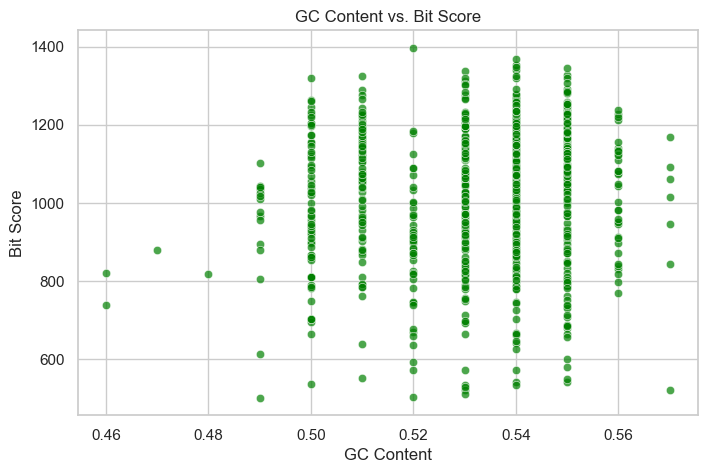

In [28]:
df["log_E_value"] = np.log10(df["E-value"].replace(0, np.nan))

# Set Seaborn style
sns.set(style="whitegrid")

# Plot 1: Histogram of Bit Scores
plt.figure(figsize=(8, 5))
sns.histplot(df["Score"], bins=30, kde=True, color="blue")
plt.xlabel("Bit Score")
plt.ylabel("Frequency")
plt.title("Distribution of Bit Scores")
plt.show()

# Plot 2: Histogram of Log E-values
plt.figure(figsize=(8, 5))
sns.histplot(df["log_E_value"].dropna(), bins=30, kde=True, color="red")
plt.xlabel("Log10(E-value)")
plt.ylabel("Frequency")
plt.title("Distribution of Log-transformed E-values")
plt.show()

# Plot 3: GC Content vs. Bit Score (Scatter)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["GC"], y=df["Score"], alpha=0.7, color="green")
plt.xlabel("GC Content")
plt.ylabel("Bit Score")
plt.title("GC Content vs. Bit Score")
plt.show()

In [162]:
ids = list(df['seq_id'])
print(ids[0])

a50104fc-fdb3-4b6d-9f1c-0c0e147cfca7


In [164]:
reads = []
names = list(names)
for nom in ids : 
    i = names.index(nom)
    reads.append(sequences[i])

In [166]:
a =[]
b=[]
sens=[]
for i in range(len(df['seq_id'])):
    a.append(df['Seq from'][i])
    b.append(df['Seq to'][i])
    sens.append(df['Strand'][i])


In [168]:
seq_to_blast = []
for i in range(len(df['seq_id'])):
    if sens[i] == '+':
        seq_to_blast.append(reads[i][a[i]: b[i]])
    else: 
        seq_to_blast.append(reads[i][b[i]: a[i]])

In [180]:
total_bases = 0
for seq in  seq_to_blast:
    total_bases += len(seq)
if total_bases % 999999 > 0:
    num_of_files = total_bases // 999999 + 1
else:
    num_of_files = total_bases // 999999
print(num_of_files)

2


In [184]:
#At some point should add the quary files into a list, especially if I start getting more of them

list_of_file_names = []
for i in range(num_of_files):
    list_of_file_names.append(f"hits_seq_{i}.fasta")


In [186]:
def split_fasta_files(list_of_file_names, seq_to_blast, max_bases=999999):
    nob = 0  
    file_index = 0  

    fasta_file = open(list_of_file_names[file_index], "w")  

    for i, seq in enumerate(seq_to_blast):
        seq_length = len(seq)
        if nob + seq_length > max_bases:
            fasta_file.close()  
            file_index += 1  
            if file_index >= len(list_of_file_names):  
                print("Warning: Not enough filenames provided!")
                break
            fasta_file = open(list_of_file_names[file_index], "w")  
            nob = 0
        fasta_file.write(f">seq_{i}\n{seq}\n")
        nob += seq_length  
    fasta_file.close()  



In [188]:
split_fasta_files(list_of_file_names, seq_to_blast)


In [31]:
blast_db = "nt" 

output_file = "blast_results.csv"


blast_command = f"blastn -query {query_fasta} -db {blast_db} -out {output_file} -outfmt '10 qseqid sseqid pident length evalue ssciname' -max_target_seqs 20"

os.system(blast_command)



print(f"BLAST results saved to {output_file}")

BLAST results saved to blast_results.csv


sh: blastn: command not found


In [127]:
def run_blast(seq_to_blast, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i in range(len(seq_to_blast)):
        filename = "blast_results_" + str(i) + ".csv"
        blast_path = os.path.join(output_dir, filename)
        blast_result = NCBIWWW.qblast("blastn", "nt", seq_to_blast[i], format_type="CSV")
        with open(blast_path, "w") as out_file:
            out_file.write(blast_result.read())
        print(f"Running blast on {blast_path}...")

In [159]:
print(seq_to_blast[3])

CCTGCAGCGGTTCATCAGTTCAGGTTAGCTCGACGCGTTTCGCGCTCAGCTACACACCCCCGGCCTATCAACGTCGTCGTCTTCAACATCAGGAGACTCTAAGTCTCAGGGAGAACTCATCTGGGGCAAGTTTCGTGCTTAGATGCTTTCAGCACTTATCTCTTCCGCATTTAGCTACCGGGCAGTGCCATTGGCATGACAACCCGAACACCGGTGATTAGTCCACTCCGGTCCTCTGATTCTCGGAGCAGCGCCCTCAGTTCTCCAGCGCCCACGGCAGATGAGACTCAACTGTCTCACGACGTTCTAAACCCAGCTCGCGTACCACTTTAAATGGCGAACAGCCATAGCCTGGGACCTACTTGAGCCCAGGATGTGATGAGCCGACATCGAGGTGCCAAACACCGCCGTCGATATGAACTCTTGGGCGGTATGGCCTGTATTATCCCGGAGTACCTTATCCGTTGAGCGATGGCCCTTCCATTCAGAACCACCGGATCACTATGACCTGCTTTCGCACCTGCTCGCGCCGTCACGCTCGCAGTCAAGCTGGCTTATGCCATTGCACTAACCTCCTGATGTCCGACAAGGATCCACCAACCTTCGTGCTCCTCCGTTACTCTTCCAGGAGGAGACCGCCGTCGAACTACCCACCGACGCTGTCCGCAACCCGGATCACGGTCCACGTTGAACATCAAACATAAAGGGTGGTATTTCAAGGCCGGCTCCATGCAGACTGGCGTCCACGCTTCAAAGCCTCCACCTATCCTACACGTGAGGCTCAATGTTCAGTGTGAGCTATAGTAAAGGTTCACGAGGATCTCCGTCTTGCCGCGGGTACACTGCATCTTCACAGCGAGTTCAATTTCACTGAGTCTCGGTGGAGACAGCCTGGCCATCATTACGCCATTCGTGCAGGTCGAACTTACCCGACAAGAGAATTCACTACCTTAGGACCGTTATAGTTACGGCCGCCGTTTACCCGGGGCTTGGATCAGGA

In [169]:
blast_result = NCBIWWW.qblast("blastn", "nt", seq_to_blast[3], hitlist_size = 20, megablast = True)
with open("test_blast.xml", "w") as out_file:
    out_file.write(blast_result.read())

In [171]:
# Open and parse the BLAST XML file
with open("test_blast.xml") as result_handle:
    blast_records = NCBIXML.read(result_handle)

blast_hits = []

for alignment in blast_records.alignments:
    for hsp in alignment.hsps:  # High-scoring pairs (matches)
        blast_hits.append({
            "Species": alignment.title.split("|")[-1],  # Extract species name
            "E-value": hsp.expect,  # Lower is better
            "Alignment Length": alignment.length,
            "Percent Identity": (hsp.identities / hsp.align_length) * 100
        })

# Convert to DataFrame for easy handling
df_species = pd.DataFrame(blast_hits)

# Sort by best matches (lowest E-value first)
# df_species = df_species.sort_values("E-value")

# Save species names & scores to CSV
df_species.to_csv("identified_species.csv", index=False)

df_species


Species  E-value  \
0     Salmonella enterica subsp. enterica serovar K...      0.0   
1     Salmonella enterica subsp. enterica serovar K...      0.0   
2     Salmonella enterica subsp. enterica serovar K...      0.0   
3     Salmonella enterica subsp. enterica serovar K...      0.0   
4     Salmonella enterica subsp. enterica serovar K...      0.0   
..                                                 ...      ...   
186   Salmonella enterica subsp. enterica serovar S...      0.0   
187   Salmonella enterica subsp. enterica serovar S...      0.0   
188   Salmonella enterica subsp. enterica serovar S...      0.0   
189   Salmonella enterica subsp. enterica serovar S...      0.0   
190   Salmonella enterica subsp. enterica serovar S...      0.0   

     Alignment Length  Percent Identity  
0             4726369         91.567088  
1             4726369         91.567088  
2             4726369         91.519074  
3             4726369         91.519074  
4             4726369         91.519074  
..                ...               ...  
186           5121989         91.876430  
187           5121989         89.482612  
188           5121989         89.908257  
189           5121989         89.818182  
190           5121989         89.272727  

[191 rows x 4 columns]

In [82]:
def run_minimap2(org_name, path_to_genome, path_to_query, output_dir, threshold = 30):
    if os.path.exists(output_dir) != True:
        os.makedirs(output_dir, exist_ok=True)
        print("makeing new folder")
    os.chdir(f"{output_dir}")
    os.makedirs(f"{org_name}", exist_ok = True)
    os.chdir(f"{org_name}")  # Change to the correct directory

    print(f"Accessed the {org_name} directory...")

    minimap2_path = "/opt/homebrew/bin/minimap2"
    samtools_path = "/opt/homebrew/bin/samtools"

    os.system(f"{minimap2_path} -ax map-ont {path_to_genome} {path_to_query} > {org_name}_map.sam")
    print("Minimap2 successful...")

    os.system(f"{samtools_path} view -bS {org_name}_map.sam > {org_name}_map.bam")
    os.system(f"{samtools_path} sort {org_name}_map.bam -o {org_name}_sorted_map.bam")
    os.system(f"{samtools_path} index {org_name}_sorted_map.bam")
    print("BAM file sorted and indexed...")

    os.system(f"{samtools_path} view -b -q {threshold} {org_name}_sorted_map.bam > {org_name}_hq.bam")
    print(f"Cutoff at {threshold} successful...")
    os.system(f"{samtools_path} index {org_name}_hq.bam")
    os.system(f"{samtools_path} stats {org_name}_sorted_map.bam > stats.txt")
    print("stats correct")
    os.chdir("../../")
    print(os.getcwd())
    

In [84]:
org_list = ["Bacillus_subtilis","Escherichia_coli", "Listeria_monocytogenes", "Pseudomonas_aeruginosa", "Salmonella_enterica", "Staphylococcus_aureus", "Enterococcus_faecalis"]
output_dir = "Maps_auto"
path_to_query = "../../combined_sequences.fasta"
for name in org_list:
    path_to_genome = "../../Genomes/" + name + "_complete_genome.fasta"
    print(path_to_genome)
    run_minimap2(name, path_to_genome, path_to_query, output_dir)



../../Genomes/Bacillus_subtilis_complete_genome.fasta
makeing new folder
Accessed the Bacillus_subtilis directory...


[M::mm_idx_gen::0.058*0.96] collected minimizers
[M::mm_idx_gen::0.067*1.21] sorted minimizers
[M::main::0.067*1.21] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.072*1.20] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.077*1.18] distinct minimizers: 737190 (98.72% are singletons); average occurrences: 1.027; average spacing: 5.345; total length: 4045677
[M::worker_pipeline::9.786*2.86] mapped 116094 sequences
[M::worker_pipeline::12.474*2.87] mapped 40724 sequences
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -ax map-ont ../../Genomes/Bacillus_subtilis_complete_genome.fasta ../../combined_sequences.fasta
[M::main] Real time: 12.479 sec; CPU: 35.778 sec; Peak RSS: 0.905 GB


Minimap2 successful...


[bam_sort_core] merging from 1 files and 1 in-memory blocks...


BAM file sorted and indexed...
Cutoff at 30 successful...
stats correct
/Users/lukabarovic/Desktop/Thesis
../../Genomes/Escherichia_coli_complete_genome.fasta
Accessed the Escherichia_coli directory...


[M::mm_idx_gen::0.063*0.99] collected minimizers
[M::mm_idx_gen::0.078*1.36] sorted minimizers
[M::main::0.078*1.36] loaded/built the index for 2 target sequence(s)
[M::mm_mapopt_update::0.085*1.33] mid_occ = 13
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 2
[M::mm_idx_stat::0.091*1.31] distinct minimizers: 879110 (97.85% are singletons); average occurrences: 1.036; average spacing: 5.352; total length: 4875441
[M::worker_pipeline::25.017*2.97] mapped 116094 sequences
[M::worker_pipeline::32.858*2.96] mapped 40724 sequences
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -ax map-ont ../../Genomes/Escherichia_coli_complete_genome.fasta ../../combined_sequences.fasta
[M::main] Real time: 32.863 sec; CPU: 97.238 sec; Peak RSS: 1.033 GB


Minimap2 successful...


[bam_sort_core] merging from 1 files and 1 in-memory blocks...


BAM file sorted and indexed...
Cutoff at 30 successful...
stats correct
/Users/lukabarovic/Desktop/Thesis
../../Genomes/Listeria_monocytogenes_complete_genome.fasta
Accessed the Listeria_monocytogenes directory...


[M::mm_idx_gen::0.042*0.98] collected minimizers
[M::mm_idx_gen::0.048*1.23] sorted minimizers
[M::main::0.048*1.23] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.053*1.22] mid_occ = 10
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.056*1.20] distinct minimizers: 546791 (98.38% are singletons); average occurrences: 1.025; average spacing: 5.341; total length: 2992342
[M::worker_pipeline::10.633*2.86] mapped 116094 sequences
[M::worker_pipeline::13.529*2.87] mapped 40724 sequences
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -ax map-ont ../../Genomes/Listeria_monocytogenes_complete_genome.fasta ../../combined_sequences.fasta
[M::main] Real time: 13.533 sec; CPU: 38.831 sec; Peak RSS: 0.789 GB


Minimap2 successful...


[bam_sort_core] merging from 1 files and 1 in-memory blocks...


BAM file sorted and indexed...
Cutoff at 30 successful...
stats correct
/Users/lukabarovic/Desktop/Thesis
../../Genomes/Pseudomonas_aeruginosa_complete_genome.fasta
Accessed the Pseudomonas_aeruginosa directory...


[M::mm_idx_gen::0.088*0.98] collected minimizers
[M::mm_idx_gen::0.129*1.61] sorted minimizers
[M::main::0.129*1.61] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.139*1.57] mid_occ = 10
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.146*1.54] distinct minimizers: 1141901 (91.83% are singletons); average occurrences: 1.110; average spacing: 5.359; total length: 6792330
[M::worker_pipeline::9.806*2.89] mapped 116094 sequences
[M::worker_pipeline::12.580*2.89] mapped 40724 sequences
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -ax map-ont ../../Genomes/Pseudomonas_aeruginosa_complete_genome.fasta ../../combined_sequences.fasta
[M::main] Real time: 12.585 sec; CPU: 36.363 sec; Peak RSS: 0.973 GB


Minimap2 successful...


[bam_sort_core] merging from 1 files and 1 in-memory blocks...


BAM file sorted and indexed...
Cutoff at 30 successful...
stats correct
/Users/lukabarovic/Desktop/Thesis
../../Genomes/Salmonella_enterica_complete_genome.fasta
Accessed the Salmonella_enterica directory...


[M::mm_idx_gen::0.065*0.98] collected minimizers
[M::mm_idx_gen::0.078*1.32] sorted minimizers
[M::main::0.078*1.32] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.085*1.29] mid_occ = 13
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.091*1.27] distinct minimizers: 861150 (97.93% are singletons); average occurrences: 1.033; average spacing: 5.351; total length: 4759746
[M::worker_pipeline::21.665*2.95] mapped 116094 sequences
[M::worker_pipeline::28.124*2.95] mapped 40724 sequences
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -ax map-ont ../../Genomes/Salmonella_enterica_complete_genome.fasta ../../combined_sequences.fasta
[M::main] Real time: 28.128 sec; CPU: 82.939 sec; Peak RSS: 1.149 GB


Minimap2 successful...


[bam_sort_core] merging from 1 files and 1 in-memory blocks...


BAM file sorted and indexed...
Cutoff at 30 successful...
stats correct
/Users/lukabarovic/Desktop/Thesis
../../Genomes/Staphylococcus_aureus_complete_genome.fasta
Accessed the Staphylococcus_aureus directory...


[M::mm_idx_gen::0.038*0.98] collected minimizers
[M::mm_idx_gen::0.044*1.25] sorted minimizers
[M::main::0.044*1.25] loaded/built the index for 4 target sequence(s)
[M::mm_mapopt_update::0.048*1.23] mid_occ = 10
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4
[M::mm_idx_stat::0.052*1.21] distinct minimizers: 491924 (97.43% are singletons); average occurrences: 1.039; average spacing: 5.344; total length: 2730326
[M::worker_pipeline::10.507*2.90] mapped 116094 sequences
[M::worker_pipeline::13.363*2.90] mapped 40724 sequences
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -ax map-ont ../../Genomes/Staphylococcus_aureus_complete_genome.fasta ../../combined_sequences.fasta
[M::main] Real time: 13.367 sec; CPU: 38.790 sec; Peak RSS: 0.943 GB


Minimap2 successful...


[bam_sort_core] merging from 1 files and 1 in-memory blocks...


BAM file sorted and indexed...
Cutoff at 30 successful...
stats correct
/Users/lukabarovic/Desktop/Thesis
../../Genomes/Enterococcus_faecalis_complete_genome.fasta
Accessed the Enterococcus_faecalis directory...


[M::mm_idx_gen::0.040*0.98] collected minimizers
[M::mm_idx_gen::0.045*1.22] sorted minimizers
[M::main::0.045*1.22] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.049*1.20] mid_occ = 10
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.053*1.19] distinct minimizers: 519616 (98.09% are singletons); average occurrences: 1.026; average spacing: 5.337; total length: 2845392
[M::worker_pipeline::10.532*2.91] mapped 116094 sequences
[M::worker_pipeline::13.578*2.91] mapped 40724 sequences
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -ax map-ont ../../Genomes/Enterococcus_faecalis_complete_genome.fasta ../../combined_sequences.fasta
[M::main] Real time: 13.581 sec; CPU: 39.565 sec; Peak RSS: 0.946 GB


Minimap2 successful...


[bam_sort_core] merging from 1 files and 1 in-memory blocks...


BAM file sorted and indexed...
Cutoff at 30 successful...
stats correct
/Users/lukabarovic/Desktop/Thesis


In [68]:
def extract_mapping_stats(org_name, output_dir):
    bam_file = os.path.join(output_dir, org_name, f"Maps_auto/{org_name}_hq.bam")
    if not os.path.exists(bam_file):
        print("BAM file not found!")
        return
    
    bam = pysam.AlignmentFile(bam_file, "rb")
    
    total_reads = 0
    mapped_reads = 0
    unmapped_reads = 0
    mapping_qualities = []

    for read in bam:
        total_reads += 1
        if read.is_unmapped:
            unmapped_reads += 1
        else:
            mapped_reads += 1
            mapping_qualities.append(read.mapping_quality)
    
    avg_mapping_quality = sum(mapping_qualities) / len(mapping_qualities) if mapping_qualities else 0
    
    bam.close()
    
    stats = {
        "Total Reads": total_reads,
        "Mapped Reads": mapped_reads,
        "Unmapped Reads": unmapped_reads,
        "Mapping Quality (Avg)": avg_mapping_quality,
        "Mapping Quality (Max)": max(mapping_qualities, default=0),
        "Mapping Quality (Min)": min(mapping_qualities, default=0)
    }
    
    df = pd.DataFrame([stats])
    output_csv = os.path.join(output_dir, org_name, f"{org_name}_mapping_stats.csv")
    df.to_csv(output_csv, index=False)
    print(f"Mapping statistics saved to {output_csv}")
    
    return df

In [70]:
df1 = extract_mapping_stats("Escherichia_coli", "statsbato")

BAM file not found!


Processing Bacillus_subtilis_complete_genome...


[M::mm_idx_gen::0.072*1.02] collected minimizers
[M::mm_idx_gen::0.081*1.23] sorted minimizers
[M::main::0.108*1.16] loaded/built the index for 1 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.112*1.15] distinct minimizers: 737190 (98.72% are singletons); average occurrences: 1.027; average spacing: 5.345; total length: 4045677
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -d minimap_results/Bacillus_subtilis_complete_genome.mmi Genomes/Bacillus_subtilis_complete_genome.fasta
[M::main] Real time: 0.115 sec; CPU: 0.132 sec; Peak RSS: 0.073 GB
[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::0.028*1.02] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.028*1.02] mid_occ = 1000
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.032*1.02] distinct minimizers: 737190 (98.72% are singletons); average occurr

Processing Enterococcus_faecalis_complete_genome...


[M::mm_idx_gen::0.040*1.01] collected minimizers
[M::mm_idx_gen::0.046*1.25] sorted minimizers
[M::main::0.064*1.18] loaded/built the index for 1 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.068*1.17] distinct minimizers: 519616 (98.09% are singletons); average occurrences: 1.026; average spacing: 5.337; total length: 2845392
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -d minimap_results/Enterococcus_faecalis_complete_genome.mmi Genomes/Enterococcus_faecalis_complete_genome.fasta
[M::main] Real time: 0.073 sec; CPU: 0.082 sec; Peak RSS: 0.054 GB
[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::0.020*1.04] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.020*1.04] mid_occ = 1000
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.023*1.03] distinct minimizers: 519616 (98.09% are singletons); averag

Processing Escherichia_coli_complete_genome...


[M::mm_idx_gen::0.064*1.01] collected minimizers
[M::mm_idx_gen::0.078*1.37] sorted minimizers
[M::main::0.108*1.27] loaded/built the index for 2 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 2
[M::mm_idx_stat::0.114*1.25] distinct minimizers: 879110 (97.85% are singletons); average occurrences: 1.036; average spacing: 5.352; total length: 4875441
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -d minimap_results/Escherichia_coli_complete_genome.mmi Genomes/Escherichia_coli_complete_genome.fasta
[M::main] Real time: 0.118 sec; CPU: 0.146 sec; Peak RSS: 0.083 GB
[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::0.035*1.02] loaded/built the index for 2 target sequence(s)
[M::mm_mapopt_update::0.035*1.02] mid_occ = 1000
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 2
[M::mm_idx_stat::0.041*1.02] distinct minimizers: 879110 (97.85% are singletons); average occurren

Processing Listeria_monocytogenes_complete_genome...


[M::mm_idx_gen::0.078*0.66] collected minimizers
[M::mm_idx_gen::0.091*0.80] sorted minimizers
[M::main::0.114*0.82] loaded/built the index for 1 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.118*0.83] distinct minimizers: 546791 (98.38% are singletons); average occurrences: 1.025; average spacing: 5.341; total length: 2992342
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -d minimap_results/Listeria_monocytogenes_complete_genome.mmi Genomes/Listeria_monocytogenes_complete_genome.fasta
[M::main] Real time: 0.123 sec; CPU: 0.101 sec; Peak RSS: 0.057 GB
[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::0.026*0.90] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.026*0.90] mid_occ = 1000
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.031*0.89] distinct minimizers: 546791 (98.38% are singletons); aver

Processing Saccharomyces_cerevisiae_draft_genome...


[M::mm_idx_gen::0.157*1.00] collected minimizers
[M::mm_idx_gen::0.217*1.55] sorted minimizers
[M::main::0.289*1.42] loaded/built the index for 51 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 51
[M::mm_idx_stat::0.305*1.39] distinct minimizers: 2077385 (91.02% are singletons); average occurrences: 1.158; average spacing: 5.337; total length: 12843354
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -d minimap_results/Saccharomyces_cerevisiae_draft_genome.mmi Genomes/Saccharomyces_cerevisiae_draft_genome.fasta
[M::main] Real time: 0.309 sec; CPU: 0.429 sec; Peak RSS: 0.174 GB
[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::0.076*1.01] loaded/built the index for 51 target sequence(s)
[M::mm_mapopt_update::0.076*1.01] mid_occ = 1000
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 51
[M::mm_idx_stat::0.092*1.01] distinct minimizers: 2077385 (91.02% are singletons);

Processing Salmonella_enterica_complete_genome...


[M::mm_idx_gen::0.063*1.00] collected minimizers
[M::mm_idx_gen::0.076*1.34] sorted minimizers
[M::main::0.105*1.25] loaded/built the index for 1 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.111*1.23] distinct minimizers: 861150 (97.93% are singletons); average occurrences: 1.033; average spacing: 5.351; total length: 4759746
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -d minimap_results/Salmonella_enterica_complete_genome.mmi Genomes/Salmonella_enterica_complete_genome.fasta
[M::main] Real time: 0.114 sec; CPU: 0.140 sec; Peak RSS: 0.081 GB
[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::0.034*1.02] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.034*1.02] mid_occ = 1000
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.040*1.02] distinct minimizers: 861150 (97.93% are singletons); average oc

Processing Staphylococcus_aureus_complete_genome...


[M::mm_idx_gen::0.037*1.02] collected minimizers
[M::mm_idx_gen::0.042*1.27] sorted minimizers
[M::main::0.060*1.19] loaded/built the index for 4 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4
[M::mm_idx_stat::0.063*1.18] distinct minimizers: 491924 (97.43% are singletons); average occurrences: 1.039; average spacing: 5.344; total length: 2730326
[M::main] Version: 2.28-r1209
[M::main] CMD: /opt/homebrew/bin/minimap2 -d minimap_results/Staphylococcus_aureus_complete_genome.mmi Genomes/Staphylococcus_aureus_complete_genome.fasta
[M::main] Real time: 0.068 sec; CPU: 0.078 sec; Peak RSS: 0.045 GB
[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::0.019*1.04] loaded/built the index for 4 target sequence(s)
[M::mm_mapopt_update::0.019*1.04] mid_occ = 1000
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4
[M::mm_idx_stat::0.022*1.03] distinct minimizers: 491924 (97.43% are singletons); averag

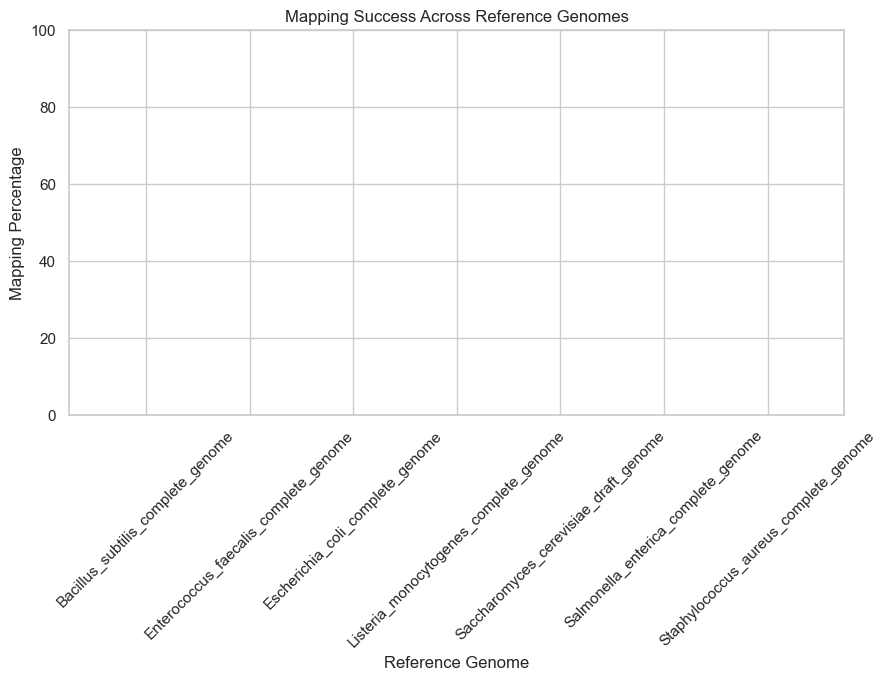

                                Reference  Total Reads  Mapped Reads  \
0       Bacillus_subtilis_complete_genome       171200             0   
1   Enterococcus_faecalis_complete_genome       176620             0   
2        Escherichia_coli_complete_genome       215764             0   
3  Listeria_monocytogenes_complete_genome       172366             0   
4   Saccharomyces_cerevisiae_draft_genome       166410             0   
5     Salmonella_enterica_complete_genome       197981             0   
6   Staphylococcus_aureus_complete_genome       172962             0   

   Mapping %  Avg Coverage  
0        0.0          7.47  
1        0.0         23.19  
2        0.0         24.31  
3        0.0         11.54  
4        0.0          1.50  
5        0.0         31.19  
6        0.0         15.16  


In [55]:
reads_fasta = "combined_sequences.fasta" 
reference_genomes = ["Genomes/Bacillus_subtilis_complete_genome.fasta", "Genomes/Enterococcus_faecalis_complete_genome.fasta", "Genomes/Escherichia_coli_complete_genome.fasta", 
                     "Genomes/Listeria_monocytogenes_complete_genome.fasta", "Genomes/Saccharomyces_cerevisiae_draft_genome.fasta", "Genomes/Salmonella_enterica_complete_genome.fasta",
                    "Genomes/Staphylococcus_aureus_complete_genome.fasta"] 

output_dir = "minimap_results"
os.makedirs(output_dir, exist_ok=True)

# Initialize results dictionary
results = []

# Loop through reference genomes and run Minimap2
for ref in reference_genomes:
    minimap2_path = "/opt/homebrew/bin/minimap2"
    samtools_path = "/opt/homebrew/bin/samtools"
    ref_name = os.path.basename(ref).split(".")[0]  # Extract base name
    index_file = f"{output_dir}/{ref_name}.mmi"
    sam_file = f"{output_dir}/{ref_name}.sam"
    bam_file = f"{output_dir}/{ref_name}.bam"
    sorted_bam = f"{output_dir}/{ref_name}_sorted.bam"

    print(f"Processing {ref_name}...")

    # Index the reference genome
    subprocess.run(f"{minimap2_path} -d {index_file} {ref}", shell=True)

    # Run Minimap2 alignment
    subprocess.run(f"{minimap2_path} -ax sr {index_file} {reads_fasta} > {sam_file}", shell=True)

    # Convert SAM to BAM, sort, and index
    subprocess.run(f"{samtools_path} view -Sb {sam_file} > {bam_file}", shell=True)
    subprocess.run(f"{samtools_path} sort {bam_file} -o {sorted_bam}", shell=True)
    subprocess.run(f"{samtools_path} index {sorted_bam}", shell=True)

    # Get mapping stats
    flagstat_output = subprocess.check_output(f"{samtools_path} flagstat {sorted_bam}", shell=True).decode()
    total_reads = int(flagstat_output.split("\n")[0].split()[0])
    mapped_reads = int(flagstat_output.split("\n")[4].split()[0])
    mapping_percentage = (mapped_reads / total_reads) * 100 if total_reads > 0 else 0

    # Get coverage stats
    depth_output = subprocess.check_output(f"{samtools_path} depth {sorted_bam}", shell=True).decode()
    coverage = [int(line.split()[2]) for line in depth_output.split("\n") if line]
    avg_coverage = sum(coverage) / len(coverage) if coverage else 0

    # Store results
    results.append({
        "Reference": ref_name,
        "Total Reads": total_reads,
        "Mapped Reads": mapped_reads,
        "Mapping %": round(mapping_percentage, 2),
        "Avg Coverage": round(avg_coverage, 2)
    })

# Convert results to DataFrame
df = pd.DataFrame(results)

# Save to CSV
df.to_csv(f"{output_dir}/mapping_results.csv", index=False)

# Plot mapping percentages
plt.figure(figsize=(10, 5))
plt.bar(df["Reference"], df["Mapping %"], color="skyblue")
plt.xlabel("Reference Genome")
plt.ylabel("Mapping Percentage")
plt.title("Mapping Success Across Reference Genomes")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show()

# Print summary
print(df)

In [52]:
df

Reference  Total Reads  Mapped Reads  \
0       Bacillus_subtilis_complete_genome       163116             0   
1   Enterococcus_faecalis_complete_genome       161709             0   
2        Escherichia_coli_complete_genome       177118             0   
3  Listeria_monocytogenes_complete_genome       163129             0   
4   Saccharomyces_cerevisiae_draft_genome       157260             0   
5     Salmonella_enterica_complete_genome       169143             0   
6   Staphylococcus_aureus_complete_genome       163440             0   

   Mapping %  Avg Coverage  
0        0.0         14.98  
1        0.0         37.84  
2        0.0         42.60  
3        0.0         23.96  
4        0.0          1.57  
5        0.0         44.16  
6        0.0         28.94

In [61]:
fasta_file = "combined_sequences.fasta"  # Replace with your actual FASTA file
reference_genome = "Genomes\Enterococcus_faecalis_complete_genome.fasta"  # Replace with your actual genome file
output_sam = "output.sam"
output_paf = "output.paf"

# Run minimap2 to generate a SAM file (for detailed alignment)
sam_command = [
    "/opt/homebrew/bin/minimap2", "-ax", "map-ont", reference_genome, fasta_file
]
with open(output_sam, "w") as sam_out:
    subprocess.run(sam_command, stdout=sam_out, check=True)

# Run minimap2 to generate a PAF file (for lightweight mapping info)
paf_command = [
    "/opt/homebrew/bin/minimap2", "-c", reference_genome, fasta_file
]
with open(output_paf, "w") as paf_out:
    subprocess.run(paf_command, stdout=paf_out, check=True)

# Function to parse PAF file into a DataFrame
def parse_paf(paf_file):
    columns = [
        "query_name", "query_length", "query_start", "query_end", "strand", 
        "target_name", "target_length", "target_start", "target_end", "num_matches", 
        "alignment_block_length", "mapping_quality"
    ]
    data = []
    with open(paf_file, "r") as f:
        for line in f:
            parts = line.strip().split('\t')
            data.append(parts[:12])  # First 12 columns contain key information
    return pd.DataFrame(data, columns=columns)

# Load mapping results
df = parse_paf(output_paf)

# Convert numeric columns to appropriate types
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Display summary statistics
print(df.describe())

# Save processed results to a CSV file
df.to_csv("mapping_results.csv", index=False)

print("Minimap2 mapping completed. Results saved in output.sam, output.paf, and mapping_results.csv.")

<>:2: SyntaxWarning: invalid escape sequence '\E'
<>:2: SyntaxWarning: invalid escape sequence '\E'
/var/folders/jg/0ky1rst55w59tncf1d8dt3900000gn/T/ipykernel_1490/3391988257.py:2: SyntaxWarning: invalid escape sequence '\E'
  reference_genome = "Genomes\Enterococcus_faecalis_complete_genome.fasta"  # Replace with your actual genome file
[ERROR] failed to open file 'Genomes\Enterococcus_faecalis_complete_genome.fasta': No such file or directory
/var/folders/jg/0ky1rst55w59tncf1d8dt3900000gn/T/ipykernel_1490/3391988257.py:2: SyntaxWarning: invalid escape sequence '\E'
  reference_genome = "Genomes\Enterococcus_faecalis_complete_genome.fasta"  # Replace with your actual genome file


CalledProcessError: Command '['/opt/homebrew/bin/minimap2', '-ax', 'map-ont', 'Genomes\\Enterococcus_faecalis_complete_genome.fasta', 'combined_sequences.fasta']' returned non-zero exit status 1.

In [90]:
def parse_samtools_stats(stats_file):
    data = {}
    
    with open(stats_file, "r") as f:
        for line in f:
            if line.startswith("SN"):  # 'SN' lines contain summary stats
                parts = line.strip().split("\t")
                if len(parts) < 3:
                    continue  # Skip malformed lines
                
                key = parts[1].strip(":")  # Remove trailing colon
                value = parts[2]

                # Convert value to float if possible
                try:
                    data[key] = float(value)
                except ValueError:
                    data[key] = value  # Keep as string if not a number

    return data  # Return as dictionary instead of DataFrame for easier merging

stats_files = ["Maps_auto/Bacillus_subtilis/stats.txt", "Maps_auto/Escherichia_coli/stats.txt", "Maps_auto/Listeria_monocytogenes/stats.txt", "Maps_auto/Pseudomonas_aeruginosa/stats.txt", "Maps_auto/Salmonella_enterica/stats.txt", "Maps_auto/Staphylococcus_aureus/stats.txt", "Maps_auto/Enterococcus_faecalis/stats.txt"]
df_list = []
for org, file in zip(org_list, stats_files):
    parsed_data = parse_samtools_stats(file)
    parsed_data["Organism"] = org  # Add organism name as a column
    df_list.append(parsed_data)

# Convert list of dictionaries into a Pandas DataFrame
df = pd.DataFrame(df_list)
df.to_csv("minimapres.csv", index=False)  # Saves without the index column

df


raw total sequences  filtered sequences  sequences  is sorted  \
0             156818.0                 0.0   156818.0        1.0   
1             156818.0                 0.0   156818.0        1.0   
2             156818.0                 0.0   156818.0        1.0   
3             156818.0                 0.0   156818.0        1.0   
4             156818.0                 0.0   156818.0        1.0   
5             156818.0                 0.0   156818.0        1.0   
6             156818.0                 0.0   156818.0        1.0   

   1st fragments  last fragments  reads mapped  reads mapped and paired  \
0       156818.0             0.0        7025.0                      0.0   
1       156818.0             0.0       84815.0                      0.0   
2       156818.0             0.0        9162.0                      0.0   
3       156818.0             0.0        9871.0                      0.0   
4       156818.0             0.0       84918.0                      0.0   
5       156818.0             0.0       10384.0                      0.0   
6       156818.0             0.0       16415.0                      0.0   

   reads unmapped  reads properly paired  ...  maximum last fragment length  \
0        149793.0                    0.0  ...                           0.0   
1         72003.0                    0.0  ...                           0.0   
2        147656.0                    0.0  ...                           0.0   
3        146947.0                    0.0  ...                           0.0   
4         71900.0                    0.0  ...                           0.0   
5        146434.0                    0.0  ...                           0.0   
6        140403.0                    0.0  ...                           0.0   

   average quality  insert size average  insert size standard deviation  \
0            255.0                  0.0                             0.0   
1            255.0                  0.0                             0.0   
2            255.0                  0.0                             0.0   
3            255.0                  0.0                             0.0   
4            255.0                  0.0                             0.0   
5            255.0                  0.0                             0.0   
6            255.0                  0.0                             0.0   

   inward oriented pairs  outward oriented pairs  \
0                    0.0                     0.0   
1                    0.0                     0.0   
2                    0.0                     0.0   
3                    0.0                     0.0   
4                    0.0                     0.0   
5                    0.0                     0.0   
6                    0.0                     0.0   

   pairs with other orientation  pairs on different chromosomes  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                             0.0   
3                           0.0                             0.0   
4                           0.0                             0.0   
5                           0.0                             0.0   
6                           0.0                             0.0   

   percentage of properly paired reads (%)                Organism  
0                                      0.0       Bacillus_subtilis  
1                                      0.0        Escherichia_coli  
2                                      0.0  Listeria_monocytogenes  
3                                      0.0  Pseudomonas_aeruginosa  
4                                      0.0     Salmonella_enterica  
5                                      0.0   Staphylococcus_aureus  
6                                      0.0   Enterococcus_faecalis  

[7 rows x 40 columns]

<Figure size 1000x500 with 0 Axes>

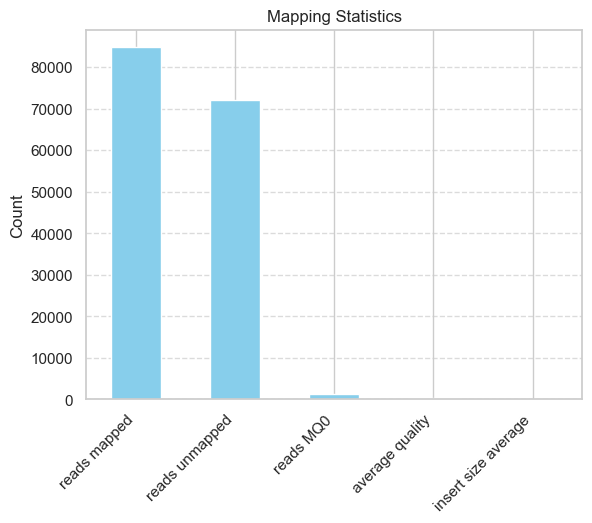

In [75]:
def plot_mapping_stats(df):
    stats_to_plot = [
        "reads mapped", "reads unmapped", "reads MQ0", "average quality", "insert size average"
    ]
    
    df_filtered = df[stats_to_plot].T  # Transpose for plotting
    df_filtered.columns = ["Values"]   # Rename column for clarity
    
    plt.figure(figsize=(10, 5))
    df_filtered.plot(kind="bar", legend=False, color="skyblue")
    plt.ylabel("Count")
    plt.title("Mapping Statistics")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Generate plot
plot_mapping_stats(df)